# STTMALST - BREAKING THE CURSE OF DIMENSIONALITY

**Feature extraction and dimensionality reduction**

_This notebook contains some of the sample code from chapter 8._

# Projection methods
Build 3D dataset:

In [1]:
import numpy as np

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## PCA using SVD decomposition

Note: the `svd()` function returns `U`, `s` and `Vt`, where `Vt` is equal to $\mathbf{V}^T$, the transpose of the matrix $\mathbf{V}$. Earlier versions of the book mistakenly said that it returned `V` instead of `Vt`. Also, Equation 8-1 should actually contain $\mathbf{V}$ instead of $\mathbf{V}^T$, like this:

$
\mathbf{V} =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$

In [2]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [3]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [4]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [5]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [6]:
X2D_using_svd = X2D

## PCA using Scikit-Learn

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [8]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [9]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [10]:
np.allclose(X2D, -X2D_using_svd)

True

Recover the 3D points projected on the plane (PCA 2D subspace).

In [11]:
X3D_inv = pca.inverse_transform(X2D)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [12]:
np.allclose(X3D_inv, X)

False

We can compute the reconstruction error:

In [13]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

The inverse transform in the SVD approach looks like this:

In [14]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstructions from both methods are not identical because Scikit-Learn's `PCA` class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [15]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

The `PCA` object gives access to the principal components that it computed:

In [16]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Compare to the first two principal components computed using the SVD method:

In [17]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Notice how the axes are flipped.

Now let's look at the explained variance ratio:

In [18]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [19]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`):

In [20]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

Let's plot the corresponding figures:

Utility class to draw 3D arrows (copied from http://stackoverflow.com/questions/11140163)

In [21]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y.

In [22]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Plot the 3D dataset, the plane and the projections on that plane.

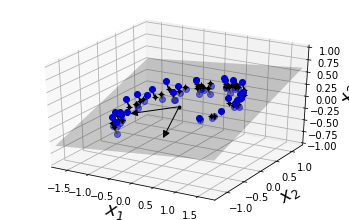

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

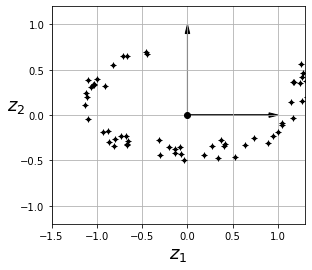

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)


# MNIST PCA compression

By retaining less of the variance in the data, PCA can be used for data compression, and the compressed data (the PCA components) can be used for training instead of the full data, which intuitively means faster processing, and in some cases also better performance.

In [25]:
from six.moves import urllib
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)


In [27]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)


In [28]:
pca = PCA(0.95) #retain 95% variance

X_reduced = pca.fit_transform(X_train) #compress

#the number of components vs. the number of original features gives you an idea about compression ratio
print(pca.n_components_) 

X_recovered = pca.inverse_transform(X_reduced) #decompress

154


In [32]:
np.shape(X_train[::2100])

(25, 784)

In [41]:
import matplotlib

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    instances = np.array(instances)
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed then Decompressed')

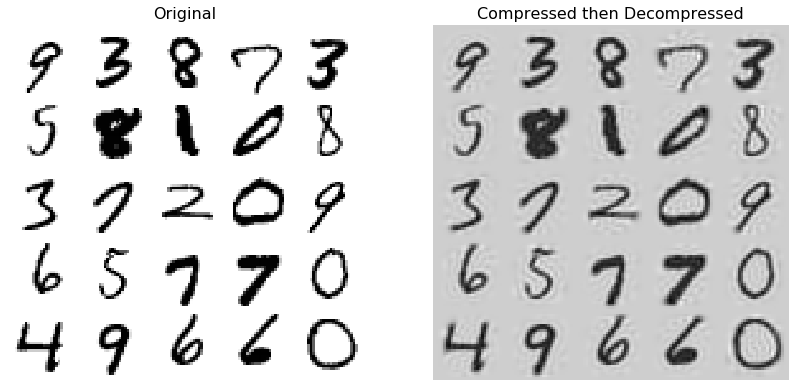

In [42]:
plt.figure(figsize=(14, 8))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed then Decompressed", fontsize=16)


Now let's see if we can speed up training significantly by training on compressed data.

Here is your baseline:

In [43]:
from sklearn.linear_model import LogisticRegression
import time

logisticRegr = LogisticRegression(solver = 'lbfgs',max_iter = 1000, multi_class = 'multinomial')

time_start = time.time()
logisticRegr.fit(X_train, y_train)
print('logisticRegr done! Time elapsed: {} seconds'.format(time.time()-time_start))

logisticRegr.score(X_test, y_test)

logisticRegr done! Time elapsed: 109.11104416847229 seconds


C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.9123428571428571

## CHALLENGE "compression" :

See if you can speed up the above by at least a factor of two while retaining similar performance, by training on compressed data (PCA components) (Don't forget to transform your test data with too). 

In [44]:
pca = PCA(.85)

time_start = time.time()
pca.fit(X_train)

X_train_proj = pca.transform(X_train)
X_test_proj = pca.transform(X_test)

logisticRegr = LogisticRegression(solver = 'lbfgs',max_iter = 1000, multi_class = 'multinomial')


logisticRegr.fit(X_train_proj, y_train)
print('logisticRegr done! Time elapsed: {} seconds'.format(time.time()-time_start))

logisticRegr.score(X_test_proj, y_test)

logisticRegr done! Time elapsed: 52.13810348510742 seconds


C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.9108

## A cautionary tale - PCA does not always improve things:

In [39]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(random_state=42)

In [40]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [41]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 3.61s


In [42]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9450285714285714

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [44]:
rnd_clf2 = RandomForestClassifier(random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\envs\tf_gpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [45]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 9.34s


Oh no! Training is actually more than twice slower now! How can that be? Well, as we saw in chapter 8, dimensionality reduction does not always lead to faster training time; it depends on the dataset, the model and the training algorithm. 

In [46]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8910285714285714

It is not uncommon for performance to drop slightly when reducing dimensionality, because we might lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help; it slowed down training and reduced performance. 

# MNIST compression for noise reduction

Now that we have seen how PCA can be used for compression and training, we move on to see how PCA compression can be used to reduce noise in data. Obviously compression reduces the size of the data, but if the data is noisy it is also possible to improve the data quality by keeping even fewer PCA components.

## CHALLENGE "noise reduction":

Add some noise to MNIST (done below already), then compare a classifier trained and tested on:

Case 1: The noisy data.

Case 2: A reduced number of PCA components from the noisy data (remember to PCA transform your test data too).

Can you find a reduced number of components that boosts performance? Different classifiers may handle noise more or less well by themselves. I tested with the SGDClassifier.


Text(0.5, 1.0, 'Noisy')

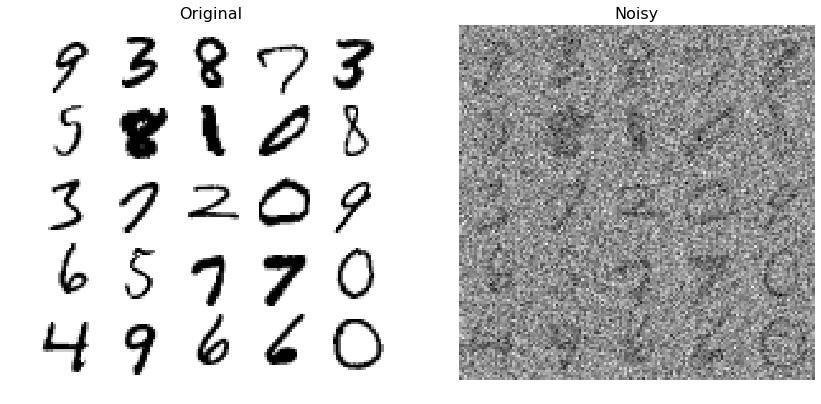

In [47]:
#generate noisy data
np.random.seed(42)
X_train_noisy = np.random.normal(X_train, 200)
X_test_noisy = np.random.normal(X_test, 200)

plt.figure(figsize=(14, 8))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_train_noisy[::2100])
plt.title("Noisy", fontsize=16)

Text(0.5, 1.0, 'Improved by Compressed')

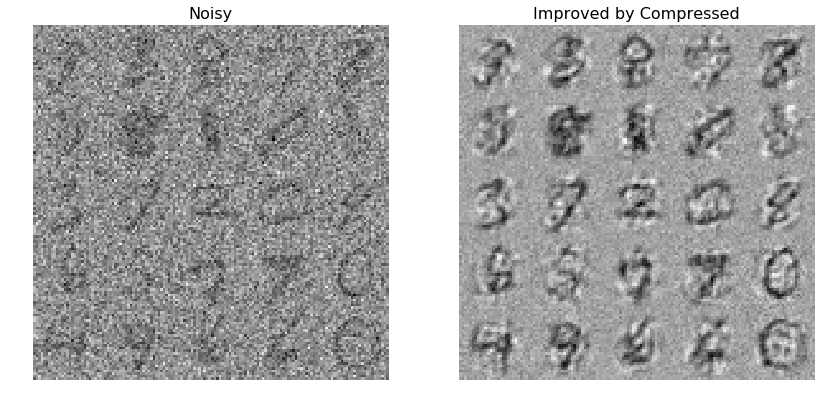

In [48]:
#test data improvement by compression
pca = PCA(n_components=0.2)
X_reduced = pca.fit_transform(X_train_noisy)
X_recovered = pca.inverse_transform(X_reduced)

plt.figure(figsize=(14, 8))
plt.subplot(121)
plot_digits(X_train_noisy[::2100])
plt.title("Noisy", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Improved by Compressed", fontsize=16)

In [53]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
X_train_noisys = scaler.fit_transform(X_train_noisy)
X_test_noisys = scaler.transform(X_test_noisy)

clf = linear_model.SGDClassifier(max_iter=100, tol=1e-3)


#scaler = StandardScaler()
#X_train_noisy = scaler.fit_transform(X_train)

#clf = MultinomialNB()

# Perform the predictions
clf.fit(X_train_noisy,y_train)
# Perform the predictions
y_predicted = clf.predict(X_test_noisy)
# Calculate the accuracy of the prediction
from sklearn.metrics import accuracy_score
print( "Accuracy = {} %".format(accuracy_score(y_test, y_predicted)*100))
# Cross validate the scores
from sklearn.metrics import classification_report
print( "Classification Report \n {}".format(classification_report(y_test, y_predicted, labels=range(0,10))))

C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\envs\tf_gpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\envs\tf_gpu\lib\site-packages\numpy\lib\arraysetops.py:518: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


Accuracy = 63.965714285714284 %
Classification Report 
               precision    recall  f1-score   support

           0       0.76      0.83      0.79      1691
           1       0.79      0.79      0.79      2006
           2       0.69      0.61      0.65      1716
           3       0.66      0.59      0.62      1793
           4       0.71      0.49      0.58      1659
           5       0.47      0.49      0.48      1628
           6       0.77      0.72      0.74      1736
           7       0.66      0.74      0.70      1836
           8       0.47      0.53      0.50      1710
           9       0.47      0.56      0.51      1725

   micro avg       0.64      0.64      0.64     17500
   macro avg       0.64      0.64      0.64     17500
weighted avg       0.65      0.64      0.64     17500



In [52]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

pca = PCA(n_components=0.2)
X_train_reduced = pca.fit_transform(X_train_noisy)
X_test_reduced = pca.transform(X_test_noisy)

scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
X_train_reduceds = scaler.fit_transform(X_train_reduced)
X_test_reduceds = scaler.transform(X_test_reduced)

#X_test_pca = pca.transform(X_test)
#X_test_pca = scaler.fit_transform(X_test_pca)

clf = linear_model.SGDClassifier(max_iter=100, tol=1e-3)


#scaler = StandardScaler()
#X_train_noisy = scaler.fit_transform(X_train)

#clf = MultinomialNB()

# Perform the predictions
clf.fit(X_train_reduceds,y_train)
# Perform the predictions
y_predicted = clf.predict(X_test_reduceds)
# Calculate the accuracy of the prediction
from sklearn.metrics import accuracy_score
print( "Accuracy = {} %".format(accuracy_score(y_test, y_predicted)*100))
# Cross validate the scores
from sklearn.metrics import classification_report
print( "Classification Report \n {}".format(classification_report(y_test, y_predicted, labels=range(0,10))))

Accuracy = 69.67999999999999 %
Classification Report 
               precision    recall  f1-score   support

           0       0.72      0.91      0.80      1691
           1       0.73      0.90      0.81      2006
           2       0.76      0.61      0.68      1716
           3       0.69      0.62      0.65      1793
           4       0.67      0.70      0.68      1659
           5       0.62      0.47      0.53      1628
           6       0.75      0.79      0.77      1736
           7       0.72      0.77      0.75      1836
           8       0.63      0.59      0.61      1710
           9       0.62      0.56      0.59      1725

   micro avg       0.70      0.70      0.70     17500
   macro avg       0.69      0.69      0.69     17500
weighted avg       0.69      0.70      0.69     17500



C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\envs\tf_gpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\envs\tf_gpu\lib\site-packages\numpy\lib\arraysetops.py:518: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [147]:
from sklearn.naive_bayes import MultinomialNB

#clf = MultinomialNB()
clf = linear_model.SGDClassifier(max_iter=100, tol=1e-3)

# Perform the predictions
clf.fit(X_train,y_train)
# Perform the predictions
y_predicted = clf.predict(X_test)
# Calculate the accuracy of the prediction
from sklearn.metrics import accuracy_score
print( "Accuracy = {} %".format(accuracy_score(y_test, y_predicted)*100))
# Cross validate the scores
from sklearn.metrics import classification_report
print( "Classification Report \n {}".format(classification_report(y_test, y_predicted, labels=range(0,10))))

C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\envs\tf_gpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\envs\tf_gpu\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


Accuracy = 88.38285714285715 %
Classification Report 
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      1755
           1       0.98      0.93      0.95      1976
           2       0.84      0.90      0.87      1732
           3       0.88      0.85      0.87      1752
           4       0.91      0.89      0.90      1680
           5       0.84      0.84      0.84      1567
           6       0.91      0.95      0.93      1743
           7       0.88      0.91      0.90      1791
           8       0.74      0.87      0.80      1755
           9       0.92      0.72      0.81      1749

   micro avg       0.88      0.88      0.88     17500
   macro avg       0.89      0.88      0.88     17500
weighted avg       0.89      0.88      0.88     17500



In [51]:
from sklearn.naive_bayes import MultinomialNB

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train_noisy)
X_test_reduced = pca.transform(X_test_noisy)

#clf = MultinomialNB()
clf = linear_model.SGDClassifier(max_iter=100, tol=1e-3)

# Perform the predictions
clf.fit(X_train_reduced,y_train)
# Perform the predictions
y_predicted = clf.predict(X_test_reduced)
# Calculate the accuracy of the prediction
from sklearn.metrics import accuracy_score
print( "Accuracy = {} %".format(accuracy_score(y_test, y_predicted)*100))
# Cross validate the scores
from sklearn.metrics import classification_report
print( "Classification Report \n {}".format(classification_report(y_test, y_predicted, labels=range(0,10))))

C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\envs\tf_gpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\au264346\AppData\Local\Continuum\anaconda3_2\envs\tf_gpu\lib\site-packages\numpy\lib\arraysetops.py:518: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


Accuracy = 44.80571428571429 %
Classification Report 
               precision    recall  f1-score   support

           0       0.56      0.48      0.52      1691
           1       0.55      0.54      0.54      2006
           2       0.45      0.52      0.48      1716
           3       0.42      0.49      0.45      1793
           4       0.41      0.45      0.43      1659
           5       0.31      0.27      0.29      1628
           6       0.52      0.48      0.50      1736
           7       0.51      0.58      0.54      1836
           8       0.37      0.31      0.34      1710
           9       0.34      0.33      0.33      1725

   micro avg       0.45      0.45      0.45     17500
   macro avg       0.44      0.44      0.44     17500
weighted avg       0.45      0.45      0.45     17500



# Manifold learning (non-linear feature extraction)
First we make a Swiss roll dataset:

In [21]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

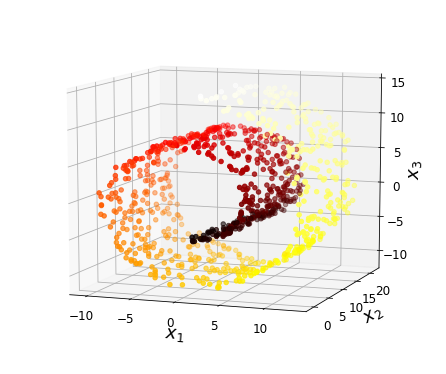

In [25]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d,Axes3D 

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
#ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

Let's compare the simple projection of the roll with the actual unrolled manifold (that we would like to learn):

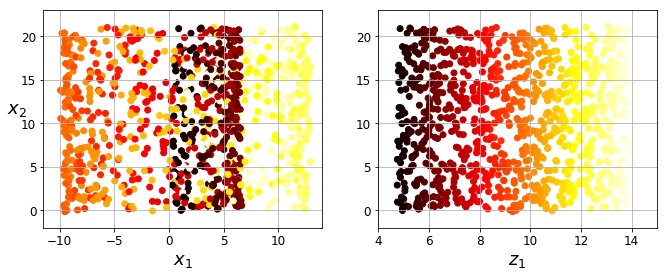

In [26]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

# Manifold learning by Kernel PCA

In [27]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

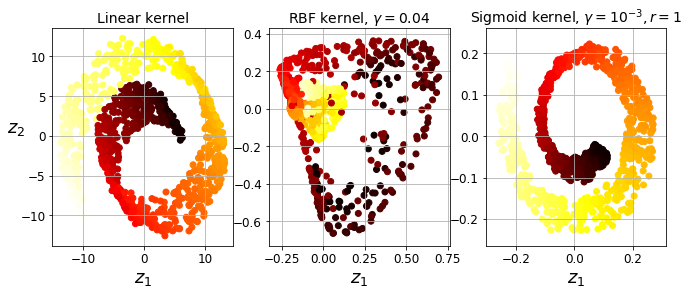

In [29]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

# Manifold learning by LLE

In [65]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


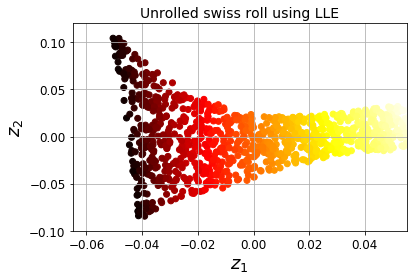

In [66]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

# Manifold learning by MDS, Isomap and t-SNE

In [30]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [31]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [32]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

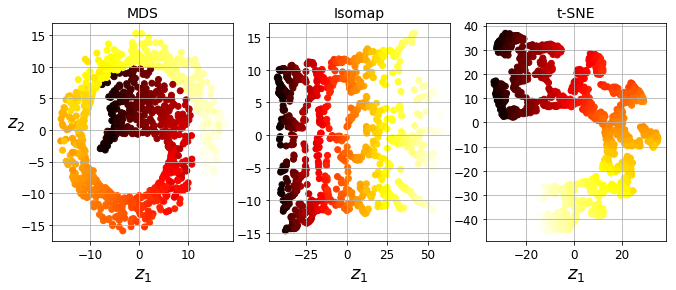

In [33]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

# Using Clustering for Preprocessing

From the above it seems t-SNE performs very well, which might be expected since it also takes a long time.

Let's try using it to visualize the MNIST data, and compare against a PCA visualization:

Let's start with PCA. We will also time how long it takes:

In [183]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X_train)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
#plot_digits(X_pca_reduced, y)
#plt.show()

PCA took 1.2s.


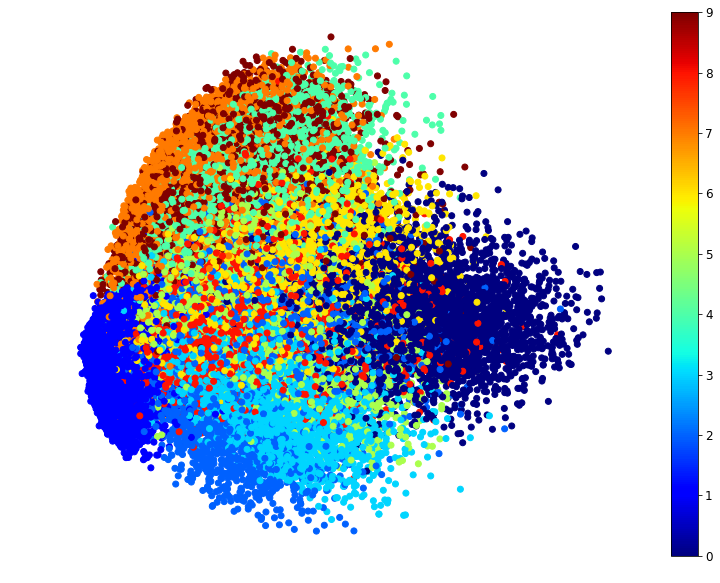

In [184]:
plt.figure(figsize=(13,10))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y_train.astype(np.int), cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

PCA is pretty fast, but although we do see a few clusters, there's way too much overlap. Let's try t-SNE:

t-SNE took 398.5s.


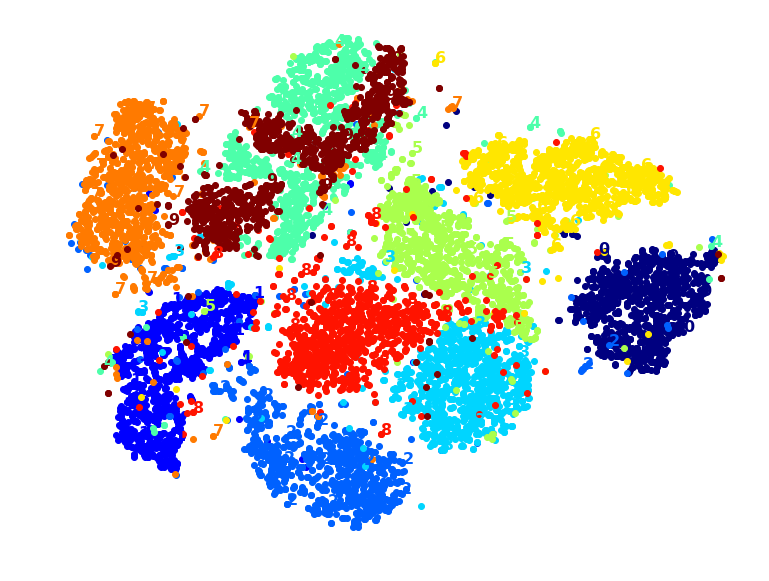

In [284]:
#OBS DON'T RUN THIS! LOOK HOW LONG IT TAKES..

from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))

plt.figure(figsize=(13,10))
plt.scatter(X_tsne_reduced[:, 0], X_tsne_reduced[:, 1], c=y_train.astype(np.int), cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Omg, that's slow. Let's see if a bit of PCA can speed it up:

In [163]:
from sklearn.pipeline import Pipeline
import time

pca_tsne = Pipeline([
    ("pca", PCA(n_components=20, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X_train)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))


PCA+t-SNE took 1039.7s.


TypeError: '<' not supported between instances of 'str' and 'int'

Yes, PCA gave us a good speedup.

Let's try it to visualize:

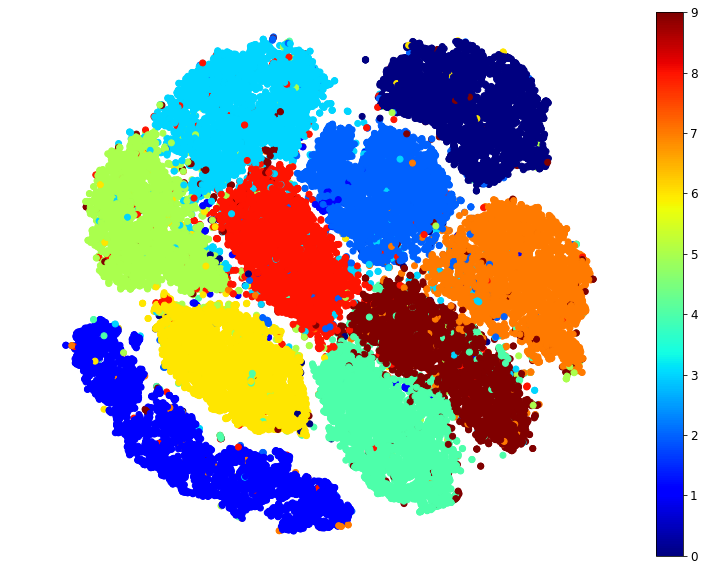

In [181]:
plt.figure(figsize=(13,10))
plt.scatter(X_pca_tsne_reduced[:, 0], X_pca_tsne_reduced[:, 1], c=y_train.astype(np.int), cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Isn't this just beautiful? :) This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often hard to distinguish (e.g., 4s and 9s, 5s and 3s, and so on).

## CHALLENGE "t-SNE features" 

From the above visualizations it seems reasonable that t-SNE will perform much better than PCA 
as feature extraction by compression as input to a classifier.

Try if you can train and test with t-SNE components (like we did earlier with PCA components). If not, explain why. 